# ADA FINAL NOTEBOOK
# Project Title: Unveiling Recipe Truth

Team members: Yan Fu, Kristijan Lopatichki, Zhechen Su

---

**IN THIS NOTEBOOK WE USE DIVIDING LINE (AS THE ONE ABOVE AND BELOW) TO DISTINGUISH MILESTONE 2 AND MILESTONE 3. JUST TO MAKE THE NOTEBOOK TIDY.**

---

# Part 0: Importing Library

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import re
from os import walk
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

In [27]:
from scipy import sparse
from visualization import *
import json
import folium
import branca.colormap as cm
import copy
from IPython.display import IFrame,display, HTML
from wordcloud import WordCloud

In [29]:
from os import walk
from time import time
import networkx as nx
from collections import Counter

In [31]:
import plotly as py
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
#import cufflinks as cf
#cf.go_offline()

In [32]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

In [33]:
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

In [34]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(8,5)})

# Part 1: Data Collection and Extraction

Generally, in this part we finished these tasks:

* Scraped over 40,000 web pages out of 93,000 html in `Cooking recipes` dataset, and created csv files with useful information ( including title of dishes, nutritions, ingredients, cooking time, cuisine type etc.)

* Cleaned and extracted data from 1.85 GB of `OpenFood.csv` data.

* Downloaded and reconstructed public health .csv files from [WHO](http://apps.who.int/gho/data/node.main.A858?lang=en) official website.

## 1.1 Dataset 1: Cooking recipes

The first dataset is `Cooking recipes`: 2.53 GB of zipped data and concludes more than 93,000 html web pages on recipes. 

1. First we use the first part of the script `move_webpages_to_folders.py` to find out how many unique websites are in `Cooking recipes` and the corresponding counts. The result of every html and their website is saved in `TotalHtml2Page.csv`. 

In [4]:
Html2Pages = pd.read_csv('./Input data/TotalHtml2Page.csv')

In [5]:
Html2Pages.head(3)

,website,htmlfile
0,www.drinksmixer.com,5af7259d1ce7d3095ccc9759c085ae17.html
1,www.drinksmixer.com,32cbba91293a8033b95a25b6301dd6a1.html
2,www.cooks.com,9123840613475868b58996e21d4b5095.html


In [6]:
Html2Pages.website.value_counts()

allrecipes.com                23696
www.food.com                  11843
www.foodnetwork.com           10000
www.cooks.com                  5525
www.yummly.com                 4827
www.epicurious.com             4228
www.tasteofhome.com            3787
www.myrecipes.com              3038
recipes.sparkpeople.com        2864
www.cdkitchen.com              2138
southernfood.about.com         2012
www.bettycrocker.com           1921
www.grouprecipes.com           1916
cookeatshare.com               1573
www.recipe.com                 1175
www.ifood.tv                   1137
www.kraftrecipes.com           1122
www.eatingwell.com             1118
www.taste.com.au                980
www.delish.com                  869
simplyrecipes.com               729
homecooking.about.com           607
www.foodandwine.com             532
nullhtml                        529
busycooks.about.com             461
www.recipetips.com              437
www.familyoven.com              406
www.drinksmixer.com         

From the results above, we can notice that we have 119 different webpages where the first three domains contain almost half of the data. To save time, we decide to do web scraping on websites with large enough counts, namely `allrecipes.com`, `food.com`, `foodnetwork.com`, `cooks.com` and `yummly.com`, whose total counts cover 60% html files of the original `Cooking Recipes` dataset.

However, `cooks.com` HTML files contained only search results but not recipes. And `yummly.com` is written in javascript structure and is too difficult to parse. Instead, we used web scraping on `yummly.com` in real time to obtain more data and parse it easier as will be shown below. Furhermore, we downloaded `yummly` dataset from another [source](http://isia.ict.ac.cn/dataset/Yummly-66K.html), which was crawled from Yummly API.

In the next steps we:

2. Decided to extract data from `allrecipes.com`, `food.com`, `foodnetwork.com` and `yummly.com`. Before that we used the second part of `move_webpages_to_folders.py` to move corresponding html files to their own folders.

3. Used scripts: `allrecipes_parsing.py`, `food_parsing.py`, `foodnetwork_parsing.py` and `yummly_parsing.py` for web scraping.

4. Generally from each web page we infer information which includes the name of the dish, preparation time, ratings, review counts, type of cuisine, the ingredients, directions for preparation and nutritional facts except in the cases where certain web pages do not contain some of the mentioned data. Saved the result as .csv file.

Things to be noticed for web scraping:

1. The html files in `Cooking recipes` include null pages or search result pages. We discarded numerous invalid HTML addresses and redundant data in the datasets and end up with around 27000 recipes in total. As for the last source `yummly.com` we have a subset of around 59607 recipes.

2. Different website used different unit(eg. minute, hour, g, kg). We transformed all the data into same unit while collecting data (eg. time all in minutes and nutritient in g or mg).

In total, we now have **86607** recipes.

In [9]:
# Load data from allrecipes.com
allrecipes = pd.read_csv('Input data/allrecipes_df.csv')
allrecipes.drop(columns='Unnamed: 0', inplace=True)

In [10]:
# Load data from food.com
food = pd.read_csv('Input data/food_df.csv')
food.drop(columns=['Unnamed: 0'], inplace=True)

In [11]:
# Load data from foodnetwork.com
foodnetwork = pd.read_csv('Input data/foodnetwork_df.csv')
foodnetwork.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
# Load data from yummly.com
yummly = pd.read_csv('Input data/yummly-all.csv')
#yummly.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)

Below we show the information we gathered from the datasets. 
1. In general, all four datasets include name of dish, review counts, ingredients and cooking time.
2. Nutrition information is lacked in foodnetwork dataset.
3. Rating is lacked in food dataset.
4. Type of cuisine is only available in foodnetwork and yummly datasets, with over 20,000 recipes.

We also noticed there is small percentage of missing values in our data. Following msno module we visualized the missing values in our data, where a white line points to a missing value. We found that for certain websites the missing rate of certain feature was high (eg. `food` not having any ratings, `yummly` missing a lot ratings).

In order to analyze on enough data examples we would better split our dataset into different categories, eg. nutritrients, ingredients, cooking time and etc, and give different analysis on different categories.

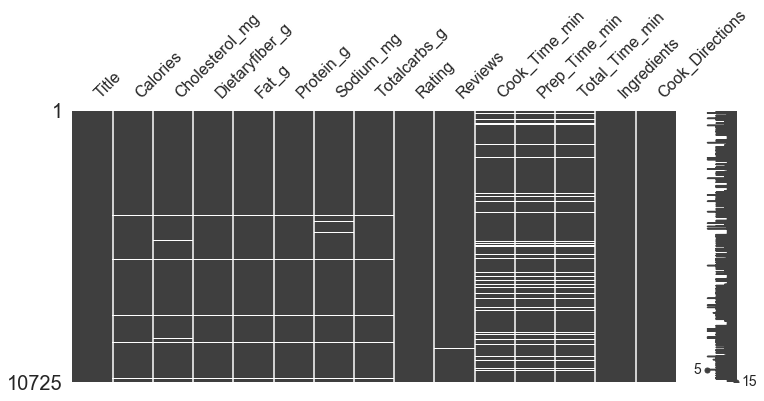

In [15]:
msno.matrix(allrecipes,figsize=(12, 5))#.info()

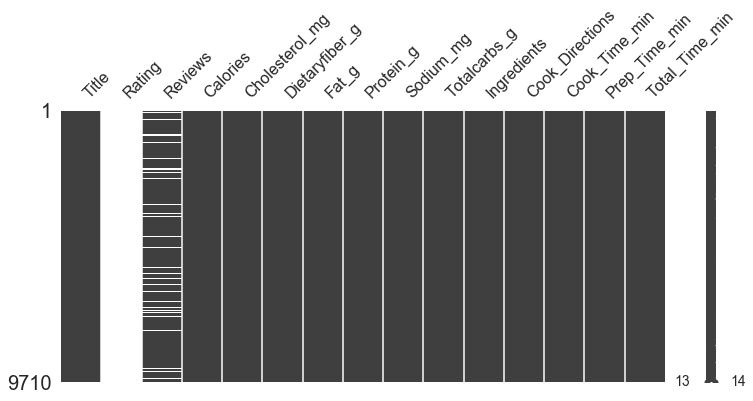

In [16]:
msno.matrix(food,figsize=(12, 5))

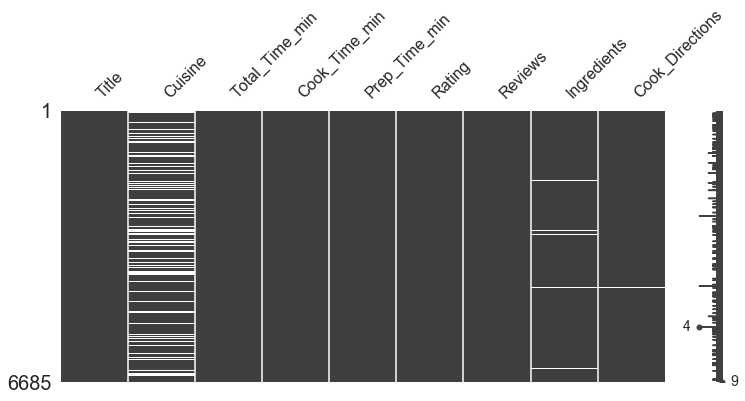

In [17]:
msno.matrix(foodnetwork,figsize=(12, 5))#.info()

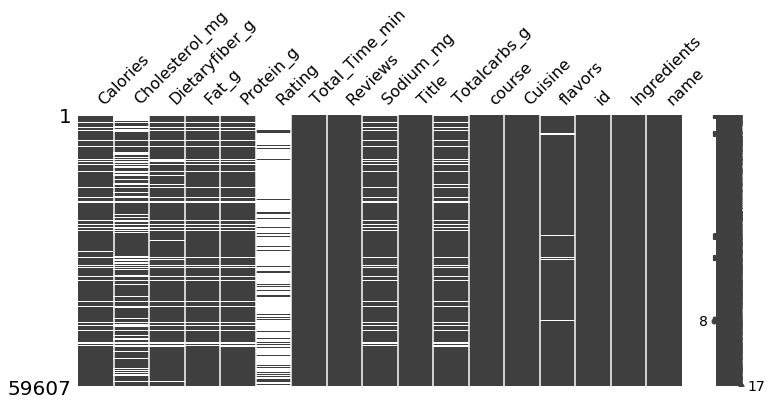

In [8]:
msno.matrix(yummly,figsize=(12, 5))#.info()

## 1.2 Dataset 2: WHO public health

Regarding our last question we include dataset [WHO](http://apps.who.int/gho/data/node.main.A858?lang=en) where we can go even further to analyze the possible relationship between regional recipes or favored ingredients and public health.

In this part we are working on the WHO dataset downloaded from WHO website. And the data including ratio of country population on:
1. High blood pressure (blood pressure over SBP140)
2. Cholesterol on two levels (190mg/dl for a little bit high and 240mg/dl for very high cholesterol)
3. BMI (BMI>25 for overweight and BMI>30 for obesity) 
4. death rate of noncommunicable diseases (including heart disease, stroke, cancer, diabetes and chronic lung disease). 

And we choose statistics data in the same year as possible.

The output data is in aggregation of risk factors and sex by **195** countries, intended to estimate regional specific public health condition. 

In [15]:
FILE_FOLDER = './dataset/WHO/'
BP_2015 = pd.read_csv(FILE_FOLDER+'BP_03.csv',skiprows=3).iloc[:,0:2] #blood pressure
BP_2015.columns = ['Country','BloodPressure']

In [3]:
NCD = pd.read_csv(FILE_FOLDER+'SDG_SH_DTH_RNCOM.csv',skiprows=1).iloc[:,0:4] # noncommunicable disease
NCD_2015 = NCD.loc[NCD.Year==2015].copy().reset_index().drop(columns=['Year','index'])
NCD_2015.columns = ['Country','Causes','Death']

In [4]:
idx = np.arange(start=0,stop=len(NCD_2015),step=4)
MalignantTumor = NCD_2015.loc[idx].copy().reset_index().drop(columns=['Causes','index'])
MalignantTumor.columns=['Country','MalignantTumor']

In [5]:
idx = np.arange(start=1,stop=len(NCD_2015),step=4)
DM = NCD_2015.loc[idx].copy().reset_index().drop(columns=['Causes','index'])
DM.columns = ['Country','DiabetesMellitus']

In [6]:
idx = np.arange(start=2,stop=len(NCD_2015),step=4)
Cardiovascular = NCD_2015.loc[idx].copy().reset_index().drop(columns=['Causes','index'])
Cardiovascular.columns=['Country','CardiovascularDiseases']

In [7]:
NCD_cause = MalignantTumor.merge(DM).merge(Cardiovascular)
NCD_cause.head(2)

,Country,MalignantTumor,DiabetesMellitus,CardiovascularDiseases
0,Afghanistan,19290,6523,49050
1,Albania,5057,168,14897


In [9]:
idx = [0,3]
Chol = pd.read_csv(FILE_FOLDER+'CHOL_05.csv',skiprows=1).iloc[:,idx]
Chol.columns = ['Country','Cholesterol']
Chol.head(2)

,Country,Cholesterol
0,Afghanistan,4.0 [1.7-8.1]
1,Albania,12.0 [5.9-21.1]


In [10]:
BMI_2015_25 = pd.read_csv(FILE_FOLDER+'NCD_BMI_25C.csv',skiprows=3).iloc[:,[0,4]]
BMI_2015_25.columns=['Country','BMI25']
BMI_2015_30 = pd.read_csv(FILE_FOLDER+'NCD_BMI_30C.csv',skiprows=3).iloc[:,[0,4]]
BMI_2015_30.columns=['Country','BMI30']
BMI = pd.merge(BMI_2015_25,BMI_2015_30,how='outer',on='Country',suffixes=('',''))#BMI
BMI.head(2)

,Country,BMI25,BMI30
0,Afghanistan,19.1 [15.5-23.3],4.3 [2.6-6.4]
1,Albania,58.0 [53.2-62.5],21.7 [17.0-26.6]


In [16]:
tmp1 = pd.merge(Chol,BMI,how='outer',on='Country',suffixes=('',''))
tmp2 = pd.merge(NCD_cause,BP_2015,how='outer',on='Country',suffixes=('',''))
WHOdata = pd.merge(tmp1,tmp2,how='outer',on='Country',suffixes=('',''))
WHOdata.to_csv('./Input data/WHOdata.csv',index=False)
WHOdata.head(2)

,Country,Cholesterol,BMI25,BMI30,MalignantTumor,DiabetesMellitus,CardiovascularDiseases,BloodPressure
0,Afghanistan,4.0 [1.7-8.1],19.1 [15.5-23.3],4.3 [2.6-6.4],19290.0,6523.0,49050.0,23.0 [17.0-29.8]
1,Albania,12.0 [5.9-21.1],58.0 [53.2-62.5],21.7 [17.0-26.6],5057.0,168.0,14897.0,31.6 [24.7-39.0]


In [6]:
## clean the WHO data set by selecting countries we are interesting in and delete [ ]
WHO_whole = pd.read_csv('./Input data/WHO_clean.csv')
WHO_whole.set_index('Country',inplace=True)

Countries = ['United States of America','France','Italy','Thailand','Mexico','China','Greece','India','Spain',\
            'Japan','Latin','Middle']
WHO = WHO_whole.loc[Countries].copy()
WHO.reset_index(inplace=True)
WHO.set_index('Country',inplace=True)

for item in WHO.columns:
    tmp = WHO[item].str.split('[ ]')
    for i in range(len(tmp)):
        WHO[item][i] = tmp[i][0]
    WHO[item] = WHO[item].astype('float')
Population = [325723,62339,57818,69064,119146,1390000,
             11233,1260000,44372,127993]
WHO['Population_k'] = Population
WHO_whole.head(2)
#WHO.to_csv('./Input data/WHO_clean.csv')

,Country,Cholesterol,BMI25,BMI30,MalignantTumor,DiabetesMellitus,CardiovascularDiseases,BloodPressure,Population_k,lat,log
0,United States of America,14.2,69.6,36.7,613063.0,81998.0,820959.0,16.4,325723,38.889931,-77.009003
1,France,20.6,62.5,22.8,172008.0,12273.0,144120.0,28.5,62339,48.864716,2.349014




# Part 2: Data process and analysis

## 2.1 Ingredients & Cuisines

For the second question we can identify the key ingredients for different recipes by counting frequency. The main ideas are:

1. Dropping words which are not ingredients in the 'Ingredients' column.
2. Counting the frequency of ingredients and getting the most popular ingredients for different cuisines.
3. Define similarity between cuisines by their shared ingredients.

### 2.1.1 Data Cleaning

In [12]:
cuisine = pd.concat([foodnetwork.iloc[:,[0,1]].copy(),yummly.iloc[:,[9,12]].copy()],sort=False)
cuisine.dropna(how='any',inplace=True)
cuisine.set_index('Title', inplace=True)

In [14]:
cuisine.Cuisine.value_counts().head(10)

American    15963
Italian      8564
French       5741
Indian       5072
Thai         4907
Chinese      4751
Greek        4741
Mexican      4703
Japanese     4411
Spanish      3804
Name: Cuisine, dtype: int64

We can see our current dataset focused mostly on American, Italian, French, Indian, Thai, Chinese, Greek, Mexican, Japanses and Spanish food.

In [10]:
ingredients_raw = pd.concat([allrecipes.iloc[:,[0,13]].copy(),food.iloc[:,[0,10]].copy(),
                     foodnetwork.iloc[:,[0,7]].copy(),yummly.iloc[:,[9,15]].copy()],sort=False)
ingredients_raw.drop_duplicates('Title', inplace=True)
ingredients_raw.set_index('Title', inplace=True)
ingredients_raw.dropna(how='all', inplace=True)

In [11]:
ingredients_raw.head(2)

,Ingredients
Title,
Baked Buffalo Wings,"['3/4 cup all-purpose flour', '1/2 teaspoon ca..."
Fast Rice Pudding,"['2 cups cooked white rice', '1 tablespoon gro..."


In [12]:
words=[]
for i in range(len(ingredients_raw.Ingredients)):
    words += list(filter(None, re.findall("[A-Za-z]*", str(ingredients_raw.Ingredients[i]))))
words_df = pd.DataFrame(words, columns=['Words'])
words_df.Words.value_counts().head(10)

cup            87725
teaspoon       56340
salt           47552
pepper         47450
oil            40024
chopped        39575
tablespoons    37860
ground         35201
cups           34351
fresh          34329
Name: Words, dtype: int64

In [13]:
words_df.Words.count()

2438826

In [33]:
np.where(words_df.Words.value_counts()>200)[0].shape

(915,)

In [15]:
ingredient = pd.read_csv('./Input data/ingredient_item.csv')
words=[]
for i in range(len(ingredient.New_ing)):
    words += list(filter(None, re.findall("[A-Za-z]*", str(ingredient.New_ing[i]))))
words_df = pd.DataFrame(words, columns=['Words'])
words_df.Words.value_counts().head(10)

pepper    55566
salt      48909
oil       45958
garlic    35790
fresh     34398
sugar     31247
ground    27348
sauce     25019
cheese    24154
olive     23873
Name: Words, dtype: int64

In [16]:
words_df.Words.count()

1590417

Above we counted the word frequency in ingredients and found that there were many non-ingredients words. And most of the words had low frequency (only 626 words out of 1,259,659 appeared more than 200 times). So we selected non-ingredient words manually from top 700 words in words_df, and saved them in a drop list.

The criteria to select non-ingredient words can be categorized into several parts:
* Numerical: 

    eg. one, two, three, four, five, six, seven, eight, nine and ten etc.


* Quantifier: 

     eg. cup, tespoon, ounce, pound, inch, gram, half, chunk, bottle, pint, quart, gram, lb, oz and their plural form.
     
     
* Food pre-processing:

    eg. peeled, melted, mixed, mashed, cracked, squeezed, deveined, evaporated, washed etc.
    
    
* Preposition:

    eg. or, for, and, to, if and etc.


* Other non-relevant words:

    eg. thick, less, part, container and etc.

In [34]:
drop_list = ['cup','teaspoon','tablespoons','cups','and','or','g','kg','ounce','tablespoon','teaspoons','to','sliced','minced',
'ounces','diced','cut','into','pound','pounds','for','inch','inches','of','freshly','finely','whole','dry',
'optional','in','piece','pieces','lb','lbs,''slice','slices','about','melted','skinless','boneless','hot','with',
'can','cans','a','as','rinsed','thick','cold','thawed','halves','at','if','on','tsp','pitted','Pinch','chunks','five',
'from','frying','you','your','smoked','juiced','tbsp','mixed','needed','serving','container','oz','blend','size',
'pint','boiling','sifted','quart','quarts','lengthwise','other','cracked','mashed','pan','bottle','bottles','squeezed',
'deveined','evaporated','de','is','washed','very','well','ml','like','it','degrees','dice','rolls','any','bag','used',
'chops','flaked','refried','reserved','chilled','rolled','split','by','only','julienned','piece','chuck','but','grams',
'unsalted','salted','less','drops','quality','refrigerated','Old','be','slivered','unbleached','inches',
'semi','F','old','part','up','loaf','peel','boiled','desired','approximately','Fresh','fresh','squares','baked','slightly',
'stemmed','blanched','undrained','choice','top','ring','rings','filling','distilled','rounds','unpeeled','peeled','slice','sprig',
'Chopped','C','I','borken','scrubbed','deep','Tbs','t','e','self','cooled','rising','rind','soaked','this','stewed',
            'cooked','taste','jar','quartered','marinated','liquid','chopped','softened','baking','drained','divivded',
             'halved',
            'one','two','three','four','five','six','seven','eight','nine','ten']

In [37]:
ing_dict = {}
for i in range(len(ingredients_raw.Ingredients)):
    ing_split = ingredients_raw.Ingredients[i].split(',')
    ing_list = []
    for j in range(len(ing_split)):
        tmp = list(filter(None,re.findall("[A-Za-z]*", str(ing_split[j]))))
        ing = ' '.join([x for x in tmp if x not in drop_list])
        ing_list.append(ing)
    ing_dict[ingredients_raw.index[i]] = ','.join(list(filter(None,ing_list)))

In [38]:
split_ingred = pd.DataFrame.from_dict([ing_dict]).T.reset_index()
split_ingred.columns = ['Title','SplitIngredients']
split_ingred.head(2)

,Title,SplitIngredients
0,Farro and White Bean Soup with Swiss Chard an...,"great northern beans,kosher salt,pepper,farro,..."
1,GREEN CHILE SWEET POTATO TACOS,"sweet potatoes,fire roasted green chiles half ..."


In [39]:
ingredients = pd.merge(ingredients_raw,split_ingred,how='inner',on='Title')
ingredients.to_csv('./Input data/ingredients.csv',index=False)
ingredients.head(2)

,Title,Ingredients,SplitIngredients
0,Baked Buffalo Wings,"['3/4 cup all-purpose flour', '1/2 teaspoon ca...","all purpose flour,cayenne pepper,garlic powder..."
1,Fast Rice Pudding,"['2 cups cooked white rice', '1 tablespoon gro...","white rice,ground cinnamon,milk,white sugar"


In [52]:
cuisine_ingr = pd.merge(ingredients,cuisine,how='inner',on='Title')

In [56]:
cuisine_ingr.to_csv('./Input data/cuisine_ingr.csv',index=False)

---
<font color='red'>
    **UPDATE FOR MILESTONE 3**
    </font>
        
To imporve the accuracy of data cleaning, we use NLP method to extract ingredients.

In [17]:
from Get_Ingredients import *

In [19]:
all_data = pd.read_csv("/Users/zhenchensu/Downloads/ingredients.csv")

In [18]:
#a simple fuction to change plural to sigle word

def sigular(st):
    if st=='chillies' or st=='chiles':  #a particular situation
        return 'chili'
    if st[-6:]=='leaves':
        return st[:-6]+'leaf' 
    if st[-3:]=='ies':
        return st[:-3]+'y'
    if st[-2:]=='es':
        return st[:-2]
    if st[-1]=='s':
        return st[:-1]
    return st

In [21]:
# main part to process
results_all = [] # to store all ingredients as a list of list
for ingred in all_data.Ingredients:
    results_one = []
    for sentence in list(ingred.strip('[\'').strip('\']').split('\', ')):
        np_extractor = NPExtractor(sentence.lower().strip('\''))
        result = np_extractor.extract()
        print(sentence)
        if result:
            k = -1
            while len(result)>abs(k) and (not list(filter(None, re.findall("[A-Za-z]*", result[k])))):
                k-=1
            if list(filter(None, re.findall("[A-Za-z]*", result[k]))):  # if exist
                results_one.append(sigular(' '.join(list(filter(None, re.findall("[A-Za-z]*", result[k]))))))  # get sigularized ingredient and append to this recipe list
            else:
                results_one.append('?') 
    print(results_one)
    results_all.append(results_one)

In [20]:
all_data['New_ing']=results_all # pd.DataFrame({'Ingredient':results_all}), axis=0)
all_data.drop(columns='Ingredients').to_csv("./Input data/ingredient_item_new.csv",index=False)
all_data.head(2)

,Title,New_ing
0,Baked Buffalo Wings,"['flour', 'cayenne pepper', 'garlic powder', '..."
1,Fast Rice Pudding,"['white rice', 'cinnamon', 'milk', 'white sugar']"


In [66]:
all_data['num_ing'] = all_data.New_ing.apply(lambda x: len(x))

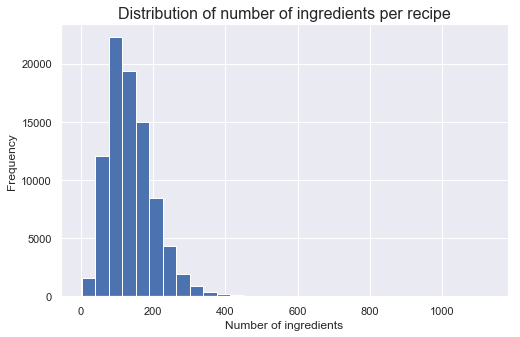

In [68]:
all_data.num_ing.hist(bins=30)
plt.title('Distribution of number of ingredients per recipe', fontsize=16)
plt.xlabel('Number of ingredients')
plt.ylabel('Frequency')
plt.show()

We can confirm from the results that most of the recipes are made from around 10 ingredients.

### 2.1.2 Most Popular Ingredients

In this part we show the main ingredients of each cuisine using wordcloud. The larger the word, the more frequently the ingredient is used. And to avoid messing up the notebook, we just take American food as an example.

And for better visualization, we use wordcloud plot created from https://wordart.com/ in our report.

In [24]:
def cuisine_ingr_topk(name,top_k):
    """
    This function is used to calculate top k mostly used ingredients in certain cuisine.
    
    Parameter:
        name: Cuisine name.
        top_k: Self defined number to choose top k mostly used ingredients.
    Return:
        Top k mostly used ingredients.
    """
    cuisine_name = name
    # counting frequency of certain cuisine type
    df = cuisine_ingr.loc[cuisine_ingr.Cuisine==cuisine_name].copy().reset_index()
    #df = cuisine_ingr
    words=[]
    for i in range(len(df.New_ing)):
        word = []
        for item in df.New_ing[i].split(','):
            tmp = list(filter(None, re.findall("[A-Za-z]*", item)))
            word.append(' '.join(tmp))
        words += word
    words_df = pd.DataFrame(words, columns=['Ingredient'])
    if top_k == 'all':
        return words_df
    else:
        return words_df.Ingredient.value_counts().head(top_k)

In [25]:
# in this part we are saving the ingredient frequency of all cuisines
for name in cuisine_ingr.Cuisine.unique():
    words_df = cuisine_ingr_topk(name,'all')
    # filename = './test/'+name+'.csv'
    #pd.DataFrame(words_df.Ingredient.value_counts()).to_csv(filename,sep=';')

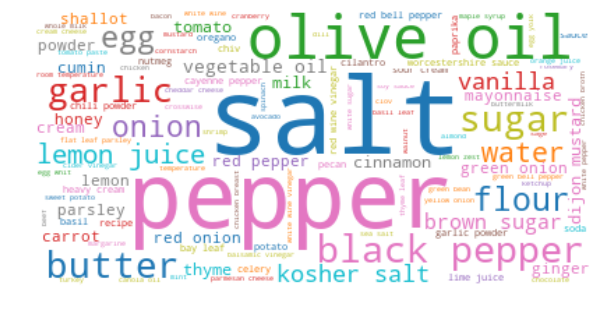

In [35]:
words_df = cuisine_ingr_topk('American','all')
freqs = words_df.Ingredient.value_counts()
fig = plt.figure(figsize=(10,10))
wc = WordCloud(background_color='white', colormap='tab10',font_step=2).generate_from_frequencies(freqs)
ax=plt.imshow(wc, interpolation='bilinear')
# plt.imsave('wc_ing.png', wc)
b=plt.axis('off')

In [37]:
words_df.Ingredient.value_counts().head(10)

salt            7816
pepper          5505
olive oil       5308
black pepper    5026
sugar           4826
butter          4647
garlic          4144
flour           3629
egg             3384
onion           2939
Name: Ingredient, dtype: int64

### 2.1.3 Cuisine Similarity
In this part we would like to see how the cuisines are connected by the number of ingredients they share. And three methods are used to evaluate on different perpectives:

1. Jaccard distance calculates the similarity of shared ingredients between different cuisines;
2. Network of cuisines shows the connections in graph;
3. T-SNE visualization uses dimension reduction to show the clusters of cuisines more directly.

### 2.1.3.1 Jaccard distance
"The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members for two sets to see which members are shared and which are distinct. It’s a measure of similarity for the two sets of data, with a range from 0% to 100%. The higher the percentage, the more similar the two populations." Quoted from [Jaccard Index](https://www.statisticshowto.datasciencecentral.com/jaccard-index/).

Here we calculate the Jaccard distance of each cuisine by their top-10 ingredients.

In [22]:
cuisine_ingr = pd.read_csv('./Input data/cuisine_ingr.csv')

In [39]:
Cuisines_type = ['American','Mexican','Thai','Chinese','Japanese','Indian',\
                'Greek','Spanish','French','Italian']

In [40]:
def get_jaccard_sim(str1, str2):
    """
    The function is used to calculate Jaccard distance between two cuisine ingredients.
    
    Parameters:
        str1,str2: Ingredients strings from cuisine1 and cuisine2.
    Return:
        Jaccard similarity of two cuisines in percentage.
    """
    a = set(str1.split(',')) 
    b = set(str2.split(','))
    c = a.intersection(b)
    return np.round(float(len(c)) / (len(a) + len(b) - len(c)),3)*100

In [41]:
cuisine_str = {}
for name in cuisine_ingr.Cuisine.unique():
    cuisine_str[name]=','.join(cuisine_ingr_topk(name,10).index)

In [42]:
cuisine_jaccard = pd.DataFrame(columns=['from','to','value'])
cuisine_adj = np.zeros((len(Cuisines_type),len(Cuisines_type)))

In [43]:
for i in range(len(Cuisines_type)):
    for j in range(i):
        cuisine1 = Cuisines_type[i]
        cuisine2 = Cuisines_type[j]
        if cuisine1!=cuisine2:
            tmp = {}
            tmp['from'] = cuisine1
            tmp['to'] = cuisine2
            tmp['value'] = get_jaccard_sim(cuisine_str[cuisine1], cuisine_str[cuisine2])
            cuisine_adj[i][j] = tmp['value']
            tmp_df = pd.DataFrame.from_dict(tmp,orient='index').T
            cuisine_jaccard = cuisine_jaccard.append(tmp_df,sort=True)
# cuisine_jaccard.to_json(orient='records')

In [48]:
cuisine_jaccard.loc[cuisine_jaccard['from']=='Italian']

,from,to,value
0,Italian,American,53.8
0,Italian,Mexican,33.3
0,Italian,Thai,11.1
0,Italian,Chinese,11.1
0,Italian,Japanese,42.9
0,Italian,Indian,25
0,Italian,Greek,42.9
0,Italian,Spanish,53.8
0,Italian,French,33.3


Take Italian food as an example. 'value' column stores the Jaccard similarity of Itanlian with other cuisines in percentage. The higher value means the more similar Itanlian food is to other cuisine. And we see that Italian food is close to American and Spanish food, and far away from Thai, Chinese and Indian food, which corresponds to real life situation.


### 2.1.3.2 Network of Cuisines

We create our adjacency matrix by counting how many ingredients each cuisine has in common with every other cuisine. Therefore, every node in our adjacency matrix represents a cuisine, and every edge is the link between two cuisines which share the same ingredinets. Every edge is represented by a weight factor or the number of ingredients in common between two cuisines.

In [87]:
df = cuisine_ingr.copy()
words=[]
for i in range(len(df.New_ing)):
    word = []
    for item in df.New_ing[i].split(','):
        tmp = list(filter(None, re.findall("[A-Za-z]*", item)))
        ing = ' '.join(tmp)
        word.append(ing.strip(' '))
    words += word
    df.New_ing[i]=word
words_df = pd.DataFrame(words, columns=['Ingredient'])

In [88]:
# Get the top 10 cuisines
cuisines = df.Cuisine.value_counts().head(10).index.values
cuisine_top10_ing = {}
for cuisine in cuisines:
    df_cuisine = df.loc[df.Cuisine==cuisine].copy().reset_index()
    words=[]
    for i in range(len(df_cuisine)):
        words += df_cuisine.New_ing[i]
    cuisine_top10_ing.update({cuisine: list(dict(Counter(words).most_common(100)).keys())})

In [89]:
# We create a dataframe with the top 10 cuisines with most common 100 ingredients
df_cuisine_top10_ing = pd.DataFrame(cuisine_top10_ing)

In [90]:
# Number of nodes for the adjacency matrix
n_nodes = df_cuisine_top10_ing.shape[1]

# Number of ingredients 
n_ing = df_cuisine_top10_ing.shape[0]

# Initialize the adjacency matrix
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

for i in range(n_nodes):
    for j in range(i+1,n_nodes):
        count=0
        for k in range(n_ing):
            count += sum(df_cuisine_top10_ing.iloc[k,i] == df_cuisine_top10_ing.iloc[:,j])
            adjacency[i,j] = adjacency[j,i] = count

In [91]:
adjacency

array([[ 0, 57, 67, 41, 43, 59, 38, 46, 60, 62],
       [57,  0, 62, 35, 36, 50, 33, 44, 53, 55],
       [67, 62,  0, 36, 38, 58, 35, 40, 57, 58],
       [41, 35, 36,  0, 32, 41, 46, 40, 39, 49],
       [43, 36, 38, 32,  0, 33, 57, 36, 55, 45],
       [59, 50, 58, 41, 33,  0, 36, 46, 53, 55],
       [38, 33, 35, 46, 57, 36,  0, 42, 52, 47],
       [46, 44, 40, 40, 36, 46, 42,  0, 48, 57],
       [60, 53, 57, 39, 55, 53, 52, 48,  0, 59],
       [62, 55, 58, 49, 45, 55, 47, 57, 59,  0]])

From the adjacency matrix we can see that every cuisine is connected with every other, or we have a fully connected graph. This is the case even when we calculate the adjacency with 10 or 1000 ingredients in common between the cuisines, where the graph is still fully connected and only edge weights are changing. Below we show a graph of our network.

/anaconda3/envs/ada/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



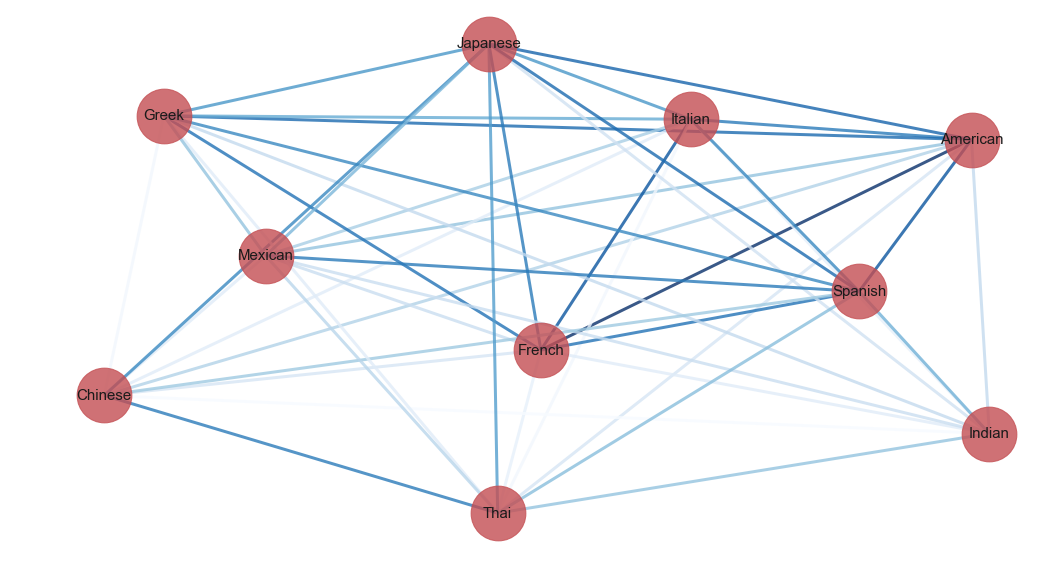

In [92]:
plt.figure(figsize=(18,10))

G = nx.from_numpy_array(adjacency)
weights = nx.get_edge_attributes(G, 'weight')
label = dict(zip(range(len(df_cuisine_top10_ing.columns.values)), df_cuisine_top10_ing.columns.values))
pos = nx.fruchterman_reingold_layout(G) 

nx.draw_networkx_edges(G, pos, alpha=0.8, width=3, edge_color=list(weights.values()), edge_cmap=plt.cm.Blues, with_labels=True)
nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), alpha=0.8, node_size=3000, node_color='r', node_shape = 'o')
nx.draw_networkx_labels(G, pos, labels=label, font_size=15, font_family='sans-serif')

plt.axis('off')
plt.show()

From the plot of our network we can infer that this is not a very good representation of the network since it can be confusing and difficult to see how strongly the cuisines are connected with each other. 


### 2.1.3.3 T-SNE Visualization

We know that every cuisine has different unique ingredients, but also shares ingredients with other cuisines. Here we are interested in finding similarities between cuisines by comparing ingredients. Since we have a huge number of ingredients per cuisine, this boils down to a dimensionality reduction problem. We will use t-SNE algorithm to reduce the dimensions of the data and create different cluster for each cuisine so we can visualize if different cuisines are similar with each other based on their ingredients.

For each recipe ingredient we use one hot encoded vector DictVectorizer from scikit learn which turns lists of mappings (dict-like objects) of feature names to feature values into Numpy arrays or scipy.sparse matrices for use with scikit-learn estimators. As mentioned above we have a huge number of recipes and cuisines. To reduce computational complexity and for better visualization we select the most popular 10 cuisines and try to find similarities between them as described.

In [93]:
def convert_to_dict(arr):
    ''' Helper function to convect an array of ingredients to a dictionary '''
    d={}
    for a in arr:
        d[a]=1
    return d

In [94]:
df['dict_ing'] = df.New_ing.apply(convert_to_dict)

In [95]:
# One hot encoding of the ingredients
vectorizer = DictVectorizer()
X = vectorizer.fit_transform(df.dict_ing.tolist())

y = df.Cuisine.astype('category').cat.codes
list_cuisine_names = df.Cuisine.astype('category').cat.categories

In [96]:
# Create filter to get the top 10 cuisines category code
filtered_cuisines = list_cuisine_names.get_indexer(df.Cuisine.value_counts().head(10).index)

# Create a mask to apply the filter
mask = y.apply(lambda x: x in filtered_cuisines)

Next, we select 2000 recipes from the top 10 cuisines in order to reduce computational time using the filter calculated above.

In [97]:
# Apply the mask and get the ingredients for the top 8 cuisines 
X_mask, y_mask = X[mask.values], y[mask]

# We select 2000 recipes to be able to represent the data, otherwise it will be too large
X_filter = X_mask[:2000]
y_filter = y_mask[:2000]

We will use t-distributed stochastic neighbor embedding or t-SNE algorithm which is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions to display our cuisines in clusters.

We use the jaccard similarity coefficient which is a statistic used for comparing the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets.

In [98]:
# Apply TSNE 
X_tsne = TSNE(n_components=3, metric='jaccard').fit_transform(X_filter.toarray())

In [99]:
# Create dataframe with the t-sne projections
df_plot = pd.DataFrame(data=X_tsne[:,:3], columns=['x','y','z'])
df_plot['cuisine'] = list_cuisine_names[y_filter].tolist()

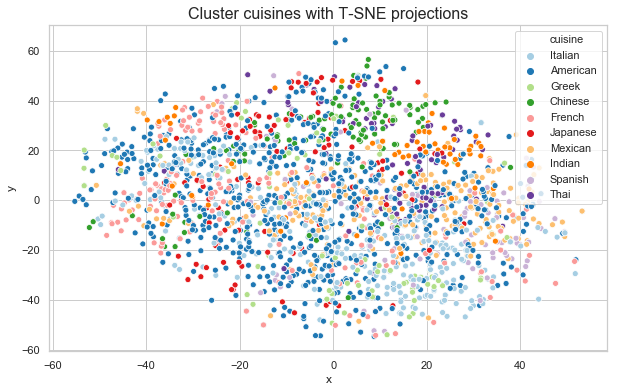

In [100]:
# Plotting the clusters on with t-sne projections
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
sns.scatterplot("x", "y", data=df_plot, palette='Paired', hue='cuisine')
plt.title('Cluster cuisines with T-SNE projections', fontsize=16)
plt.show()

Judging from the plot above we can clearly state that the cuisines are almost grouped in different clusters, where if one cuisine is overlapping with another means that they are similar by the metric for similarity that we have used in the t-SNE algorithm. It is clear that recipes from different cuisines do not always share the same basic ingredients and are not overlapping (e.g. Chinese and Italian). 

In order to gain more inside for similarity between different cuisines, we use a 3D interactive plot where we can filter between cuisines to see which ones are most similar. For example, when we show only Chinese and Thai cuisine on the 3D plot we can confirm that these cuisine clusters are very close to each other and we classify them as similar. When we add French and Italian cuisines on the plot besides Chinese and Thai for example, we can see that these groups are two different types of cuisines which is probably due to geographical and cultural dissimilarities. This plot will be used in our webpage.

**More visualization is included in our report.**

<font color='red'>
    **END OF UPDATE FOR MILESTONE 3**
    </font>
        
---

## 2.2 Nutritients

We start with creating `Nutritients` category which will provide us with nutritional information for every recipe available. Since we have nutritional information from `allrecipes.com`, `food.com` and `yummly.com` we create our dataframe from these dataframes.

In [10]:
nutrients = pd.concat([allrecipes.iloc[:,0:8],food.iloc[:,[0,3,4,5,6,7,8,9]].copy(),yummly.iloc[:,[9,0,1,2,3,4,8,10]].copy()],sort=False)
nutrients.drop_duplicates('Title',inplace=True)
nutrients.set_index('Title', inplace=True)
nutrients.dropna(how='all', inplace=True)
nutrients.head(2)

,Calories,Cholesterol_mg,Dietaryfiber_g,Fat_g,Protein_g,Sodium_mg,Totalcarbs_g
Title,,,,,,,
Baked Buffalo Wings,125.0,32.0,0.2,9.2,6.8,258.0,3.8
Fast Rice Pudding,424.0,33.0,1.6,8.9,10.6,121.0,76.2


From the plot below we can explore the distibutions for all nutrients in the recipes and their correlation. 

From the plot we know very few recipes with extremly high values in the nutrients. We can see that calorie almost has a linear relation with fat and total carbonhydrate, which makes sense. We have a couple of features which are correlated and follow a power law like cholesterol vs. sodium, fat vs. sodium etc. 

We will use this information when we connect the recipe data with the WHO data to explore correlation on health and recipes nutrients. 

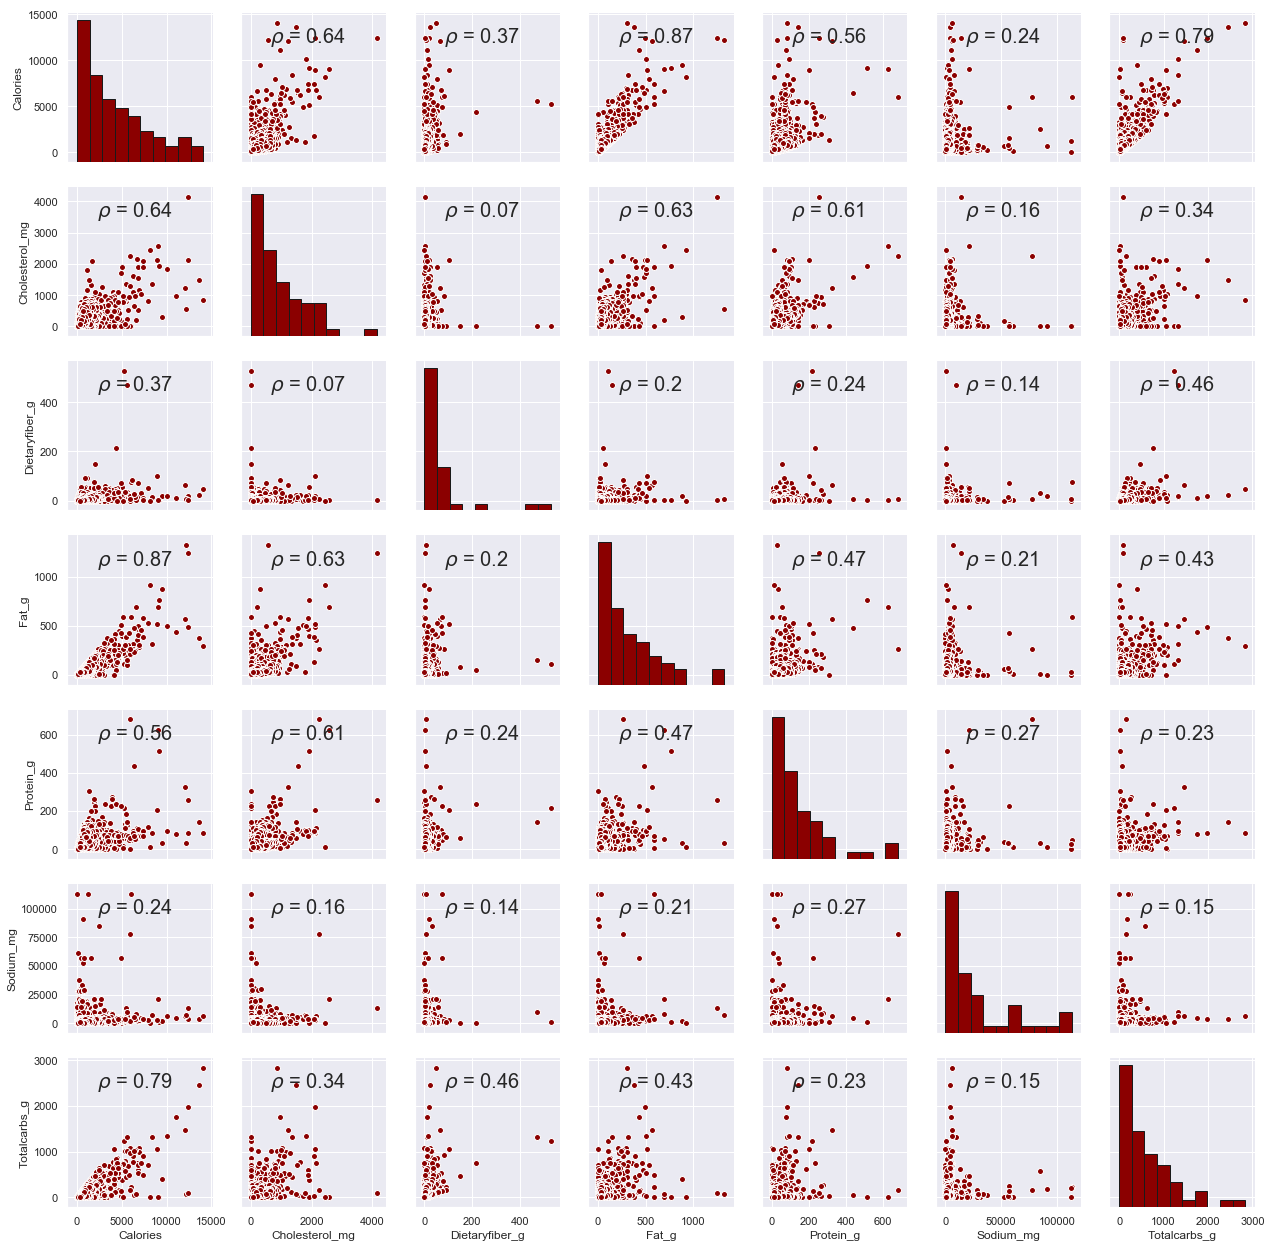

In [56]:
# sns.pairplot(nutrients.dropna())
def corr(x, y, **kwargs):
    # Calculate Pearson Corr
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.8), size = 20, xycoords = ax.transAxes)
# Create a pair grid instance
grid = sns.PairGrid(data= nutrients.dropna())

# Map the plots to the locations
grid = grid.map_upper(plt.scatter, edgecolors='white', color = 'darkred')
grid = grid.map_upper(corr)
grid = grid.map_diag(plt.hist, log = True, bins = 10, edgecolor = 'k', color = 'darkred')
grid = grid.map_lower(plt.scatter, edgecolors='white', color = 'darkred')
grid = grid.map_lower(corr)

---
<font color='red'>
    **UPDATE FOR MILESTONE 3**
    </font>
        


In [49]:
# To be more typical we pick up top-100 most popular recipes in each cuisine and calculate the average nutrient.
def print_nutri(cuisine_name,inputdf,top_k):
    """
    The function is used to calculate average nutritient information of each ingredient.
    """
    df = inputdf.loc[inputdf.Cuisine==cuisine_name].copy().reset_index()
    df = df.sort_values(by='Reviews',ascending=False).head(top_k)
    nutris_len = [df.Calories.mean(),df.Cholesterol_mg.mean(),df.Fat_g.mean(),df.Protein_g.mean(),
                  df.Sodium_mg.mean(),df.Totalcarbs_g.mean()]
    return nutris_len

In [52]:
cuisine_nutri = pd.read_csv('./Input data/cuisine_nutri.csv')

Cuisines_type = ['American','Mexican','Thai','Chinese','Japanese','Indian',\
                'Greek','Spanish','French','Italian']
Countries = ['United States of America','Mexico','Thailand','China','Japan','India',\
             'Greece','Spain','France','Italy']

In [57]:
nutri_dict = {}
for i in range(len(Cuisines_type)):
    tmp = print_nutri(Cuisines_type[i],cuisine_nutri,100)
    nutri_dict[Countries[i]] = tmp
unhealth_df = pd.DataFrame.from_dict(nutri_dict).T
unhealth_df.columns = ['Calories','Cholesterol','Fat','Protein','Sodium','Carbonhydrate']
# unhealth_df.to_csv('./Input data/unhealth_df.csv')
unhealth_df.reset_index(inplace=True)
unhealth_df.rename(columns={'index': 'Country'}, inplace=True)

In [58]:
WHO = pd.read_csv('./Input data/WHO_clean.csv')
WHORecipe = unhealth_df.merge(WHO[['Country','Cholesterol','BMI25','BMI30']],on='Country',\
                  suffixes=('_recipe','_WHO')).round(2)
# WHORecipe.to_csv('./Input data/WHORecipe.csv',index=False)
WHORecipe

,Country,Calories,Cholesterol_recipe,Fat,Protein,Sodium,Carbonhydrate,Cholesterol_WHO,BMI25,BMI30
0,United States of America,494.86,140.24,24.08,20.27,674.48,49.49,14.2,69.6,36.7
1,Mexico,381.13,84.58,17.72,22.75,919.42,34.21,13.9,63.5,27.8
2,Thailand,380.34,102.23,19.02,21.18,897.20,33.61,15.7,33.6,10.1
3,China,514.15,101.74,27.55,29.59,1450.38,36.77,7.2,32.9,6.2
4,Japan,280.64,86.12,12.88,18.54,1302.71,21.29,15.8,29.0,4.2
5,India,514.24,146.50,28.84,32.22,882.19,32.94,5.3,18.7,3.6
6,Greece,321.47,73.11,15.04,13.91,574.70,34.62,12.8,66.5,26.9
7,Spain,372.33,88.79,16.85,17.69,634.02,38.26,16.4,66.6,26.6
8,France,428.03,193.79,21.26,13.52,519.85,46.09,20.6,62.5,22.8
9,Italy,415.83,110.78,21.60,23.53,682.49,31.55,20.1,63.6,22.5


In this plot we first normalized the data to zero mean and 1 standard deviation for the sake of scaling all nutritients in same range. And since we only care about the tendency so this normalization does not hurt our analysis.

[Text(0, 0, 'United States of America'),
 Text(0, 0, 'Mexico'),
 Text(0, 0, 'Thailand'),
 Text(0, 0, 'China'),
 Text(0, 0, 'Japan'),
 Text(0, 0, 'India'),
 Text(0, 0, 'Greece'),
 Text(0, 0, 'Spain'),
 Text(0, 0, 'France'),
 Text(0, 0, 'Italy')]

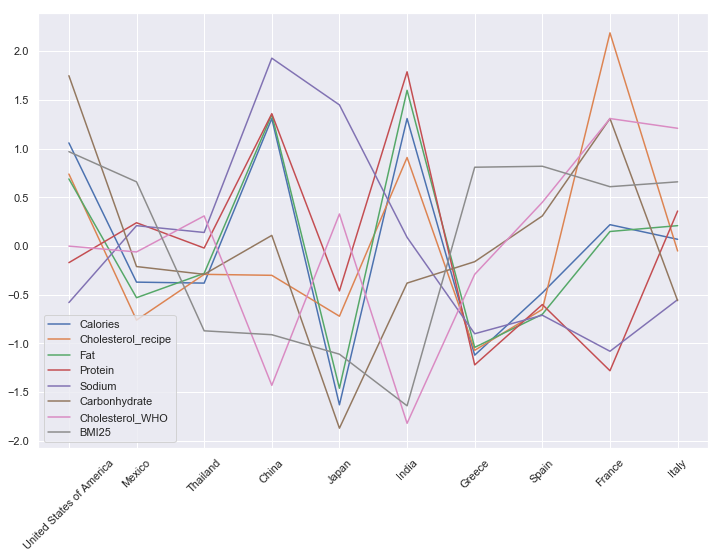

In [56]:
WHORecipe_df=(WHORecipe.iloc[:,1:10]-WHORecipe.iloc[:,1:10].mean())/WHORecipe.iloc[:,1:10].std()
WHORecipe_df = WHORecipe_df.round(2)
ax = WHORecipe_df.iloc[:,0:8].plot(xticks=WHORecipe_df.index, rot=45,figsize=(12,8))
ax.set_xticklabels(WHORecipe.Country)

Geometrically, Asian countries share same features of high sodium ,low carbonhydrate and low cholesterol, while European countries are relatively low in sodium, calories protein and fat. The US is high in carbonhydrate, fat, calories and cholesterol. And its neighbour, Mexico, seems to be more healthy with slightly high in protein and sodium and low in all other nutritients.

Actually public health is influenced by many factors. Eating habit is just one of these factors, but it can still explain something. For example, the US has the highest overweight percentage in its population, coinciding its eating habit in high carbonhydrate, fat, calories and cholesterol. French recipe has highest averaged cholesterol and its percentage of population with total cholesterol ≥ 190 mg/dl is also the highest. 

And we can go even further. Take Chinese and Japanese food as an example. China and Japan are close geometrically and both in Sinosphere (Eastern Asian cultural sphere), and they have high similarity in ingredients but differ a lot in nutritients. The difference may result from cooking method. Japanese food tends to use light seasoning and serves the food in their natrual state, while Chinese prefers the opposite way, using plenty of seasonings to create complicated flavors and use pan frying.

Also, readers can develop deeper comparison on European countries (Greece, Spain, France and Italy). It will be interesting to find things in common and things in diffenrent and reasons lying behind.

Besides, we want to mention that the recipes we collected mainling came from foodnetwork and yummly, both American website. The regional recipes on these websites are not that typical of corresponding countries. For example, the top 10 most popular Chinese recipes shown above are unfamiliar to Chinese, and the third dish 'Asian Orange Chicken' is just something created in the US. All these factors affect our analysis. To get more accurate result we need an unbiased dataset.

 [The determinants of health](https://www.who.int/hia/evidence/doh/en/)

In [59]:
# this part is for drawing nutritient map for our cuisines
topo_json_data = json.load(open(r'./Map/world-countries.json'))

m = folium.Map([43,-10], tiles='cartodbpositron', zoom_start=1.5)
country_list = ['United States of America','France','Italy','Thailand','Mexico','China','Greece','India',
             'Spain','Japan']

layer1 = global_visualization(topo_json_data,country_list,unhealth_df,'Cholesterol',layer_name='RecipeCholesterol')
layer1.add_to(m)

layer2 = global_visualization(topo_json_data,country_list,unhealth_df,'Calories',layer_name='RecipeCalories')
layer2.add_to(m)

layer3 = global_visualization(topo_json_data,country_list,unhealth_df,'Fat',layer_name='RecipeFat')
layer3.add_to(m)

layer4 = global_visualization(topo_json_data,country_list,unhealth_df,'Protein',layer_name='RecipeProtein')
layer4.add_to(m)

layer5 = global_visualization(topo_json_data,country_list,unhealth_df,'Sodium',layer_name='RecipeSodium')
layer5.add_to(m)

layer6 = global_visualization(topo_json_data,country_list,unhealth_df,'Carbonhydrate',layer_name='RecipeCarbonhydrate')
layer6.add_to(m)

# df = pd.read_csv('./Input data/WHO_clean.csv',index_col='Country')
# factor = 'Cholesterol'
# layer2 = global_visualization(topo_json_data,country_list,df,factor,layer_name=factor)
# layer2.add_to(m)

folium.LayerControl(collapsed = True).add_to(m)
folium.Map.save(m, 'RecipeAvgNutri.html')
#IFrame(src='test.html',width=980,height=600)


**Again, more visualizaiton is displayed in our wab page.**

<font color='red'>
    **END OF UPDATE FOR MILESTONE 3**
    </font>
        
---

## 2.3 Rating & Review

- In this part we find top-10 most popular recipes for each cuisine by number of reviews.

Next we will create a new `Ratings` category containing information about ratings for every recipe available. Since we have ratings information from `allrecipes.com`, `foodnetwork.com` and `yummly.com` we create our dataframe from these dataframes.

In [60]:
ratings = pd.concat([allrecipes.iloc[:,[0,8]].copy(),foodnetwork.iloc[:,[0,5]].copy(),yummly.iloc[:,[9,5]].copy()])
print(ratings.count())
ratings.set_index('Title', inplace=True)
ratings.dropna(how='all', inplace=True)

Title     77017
Rating    27037
dtype: int64


Here we have 27037 ratings for recipes out of 77017 recipes.

Next we will create a new `Reviews` category containing information about number of reviews for every recipe available. We have reviews information from every webpage datafreme available.

In [18]:
reviews = pd.concat([allrecipes.iloc[:,[0,9]].copy(),food.iloc[:,[0,2]].copy(),
                     foodnetwork.iloc[:,[0,6]].copy(),yummly.iloc[:,[9,7]].copy()])
print(reviews.count())
reviews.set_index('Title', inplace=True)
reviews.dropna(how='all', inplace=True)

Title      86727
Reviews    85468
dtype: int64


---
<font color='red'>
    **UPDATE FOR MILESTONE 3**
    </font>
        


In [19]:
cuisine_review = ratings.merge(cuisine,how='outer',on='Title').merge(reviews,how='outer',on='Title')

In [25]:
cuisine_review.drop_duplicates(inplace=True)

In [27]:
cuisine_review = cuisine_review.sort_values(by='Reviews',ascending=False)

In [43]:
Cuisine_type = ['Italian', 'American', 'Greek', 'Chinese', 'French', 
                'Japanese','Mexican', 'Indian','Spanish', 'Thai']

In [44]:
cuisine_review_top10 = pd.DataFrame(columns=['Rating','Cuisine','Reviews'])

In [47]:
for name in Cuisine_type:
    tmp = cuisine_review.loc[cuisine_review.Cuisine==name]
    tmp = tmp[~tmp.index.duplicated(keep='first')].head(10)
    cuisine_review_top10 = cuisine_review_top10.append(tmp)

In [51]:
cuisine_review_top10 = cuisine_review_top10.append(cuisine_review.head(10))

In [53]:
cuisine_review_top10.to_csv('./Input data/cuisine_review_top10.csv')

In [64]:
cuisine_review_top10 = pd.read_csv('./Input data/cuisine_review_top10.csv')
cuisine_review_top10.columns = ['Recipes','Rating','Cuisine','Reviews']

In [65]:
cuisine_review_top10.loc[cuisine_review_top10.Cuisine=='Thai']

,Recipes,Rating,Cuisine,Reviews
90,Asian Lettuce Wraps,4.6,Thai,993.0
91,Chicken Satay,4.0,Thai,429.0
92,Teriyaki Chicken,4.6,Thai,383.0
93,Asian Coleslaw,5.0,Thai,367.0
94,5 Ingredient Coconut Curry,4.5,Thai,325.0
95,Thai Peanut Chicken,4.0,Thai,320.0
96,Thai Pineapple Chicken Curry,4.5,Thai,264.0
97,Pad Thai,4.5,Thai,258.0
98,Spicy Turkey Burgers,5.0,Thai,243.0
99,Slow Cook Thai Chicken,5.0,Thai,233.0


Take Thai food as example. We can see the most popular recipes are very Thai style and they all have high rating scores.

**Again, more visualizaiton and full data is displayed in our wab page.**

<font color='red'>
    **END OF UPDATE FOR MILESTONE 3**
    </font>
        
---

## 2.4 Cooking time

---
<font color='red'>
    **UPDATE FOR MILESTONE 3**
    </font>
        



Next we will create a new `Total cooking time` category containing information about the total time needed to make the recipe for every recipe available. We have total cooking time information from every webpage datafreme available.

In [107]:
cuisine_ingr = pd.read_csv('./Input data/new_ingred_cuisine.csv')
total_cook_time = pd.concat([allrecipes.iloc[:,[0,12]].copy(),food.iloc[:,[0,14]].copy(),
                     foodnetwork.iloc[:,[0,2]].copy(),yummly.iloc[:,[9,6]].copy()])
total_cook_time.dropna(how='all', inplace=True)
time_cuisines = cuisine_ingr.merge(total_cook_time, left_on='Title', right_on='Title')

In [108]:
cuisine_ingr.head()

,Title,Cuisine,New_ing
0,Farro and White Bean Soup with Swiss Chard an...,Spanish,"['great northern bean', 'kosher salt', 'pepper..."
1,GREEN CHILE SWEET POTATO TACOS,Mexican,"['sweet potato', 'green chil', 'garlic', 'cumi..."
2,Mexican Street Corn Salad With Black Beans an...,Mexican,"['mayonnaise', 'chipotle chile pepper', 'garli..."
3,Recipes,Indian,"['fish', 'turmeric', 'onion', 'garlic paste', ..."
4,Shrimp Chow Mein,Chinese,"['chinese egg noodl', 'soy sauce', 'oyster sau..."


Here we want to show how the total cooking time varyes in different cuisines. We calculate the cumulative distribution of cooking time for each cuisine and create one plot for easier comparison. 

We suppose that cooking time may differ depending on the types of ingredients or the techniques involved in the cooking process (baking, frying, grilling, roasting, steaming).

From the results on the plot we can notice that the French and Spanish cuisines have around 50% of their recipes with cooking time less than 50 minutes and would be classified as less time demanding cuisines, while the Greek and Thai cuisines have around 85% of their recipes with cooking time less than 50 minutes and would be classified as time demanding cuisines. 

/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in less_equal



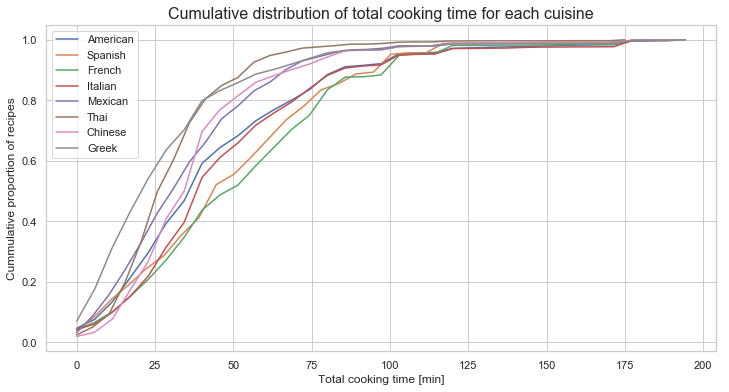

In [109]:
plt.figure(figsize=(12,6))

cuisine_sample = time_cuisines.Cuisine.value_counts().head(8).index.values

# Calculate the cumulative distribution of the total cooking time for each cuisine 
for cuisine in cuisine_sample:
    total_time = time_cuisines.loc[time_cuisines.Cuisine==cuisine, 'Total_Time_min'].values
    total_time = total_time[total_time <= 200]
    values, base = np.histogram(total_time, bins=35)
    cumulative = np.cumsum(values)
    cumulative = cumulative/cumulative.max()
    ax = plt.plot(base[:-1], cumulative)
plt.ylabel('Cummulative proportion of recipes', fontsize=12)
plt.xlabel('Total cooking time [min]', fontsize=12)
plt.title('Cumulative distribution of total cooking time for each cuisine', fontsize=16)
plt.legend([x for x in cuisine_sample])
plt.grid(True)
plt.show()

**Again, more visualizaiton and full data is displayed in our wab page.**

<font color='red'>
    **END OF UPDATE FOR MILESTONE 3**
    </font>
        
---